# Resume Scoring & Percentile Ranking

**Objective**: Create a multi-factor scoring algorithm and percentile ranking system

## Goals:
1. Design weighted scoring algorithm
2. Calculate resume scores (0-100)
3. Implement percentile ranking (overall + by category)
4. Create job-resume matching function
5. Analyze score distributions
6. (BONUS) Implement skill gap analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import joblib
import json

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Clustered Data

In [2]:
# Load data with cluster assignments
df = pd.read_csv('../data/processed/resumes_clustered.csv')

print(f"✓ Loaded data: {df.shape}")
print(f"  Records: {len(df)}")
print(f"  Features: {len(df.columns)}")

# Check cluster distribution
if 'Cluster_KMeans' in df.columns:
    print(f"\nCluster distribution:")
    print(df['Cluster_KMeans'].value_counts().sort_index())

df.head()

✓ Loaded data: (495, 62)
  Records: 495
  Features: 62

Cluster distribution:
Cluster_KMeans
0    109
1    154
2     53
3     38
4     37
5     42
6     51
7     11
Name: count, dtype: int64


,ID,Category,Resume,Experience_Years,Education_Level,Skills,Num_Skills,Has_Certification,Num_Companies,Resume_str,...,Category_Web Development,Has_Certification_Encoded,Has_Leadership_Encoded,Cluster_KMeans,Cluster_Name,Cluster_Hierarchical,PCA1,PCA2,TSNE1,TSNE2
0,SYN_0001,Web Development,Full Stack Developer with 3 years of experienc...,-0.491615,Bachelor's,"Node.js, CSS, JavaScript, Redux, Vue.js, Expre...",0.192366,False,-0.627279,Unknown,...,True,-0.858395,-0.879883,6,Entry-Level Focused Technical Specialists,2,0.698759,-1.740735,13.601857,2.206011
1,SYN_0002,Web Development,Full Stack Developer with 9 years of experienc...,1.870999,Bachelor's,"Node.js, REST APIs, MySQL, Vue.js, PostgreSQL,...",1.445273,False,2.624062,Unknown,...,True,-0.858395,1.136515,6,Entry-Level Focused Technical Specialists,2,3.250912,1.443623,20.460583,5.988521
2,SYN_0003,Software Engineering,Software Engineer with 6 years of experience. ...,0.689692,Master's,"Go, Programming, SQL, JavaScript, Algorithms, ...",0.505593,False,0.998392,Unknown,...,False,-0.858395,1.136515,7,Entry-Level Focused Non-Technical,0,1.704223,3.378965,-15.355491,-7.620644
3,SYN_0004,Web Development,Full Stack Developer with 5 years of experienc...,0.295923,Master's,"Node.js, CSS, Angular, JavaScript, MySQL, Vue....",1.132046,True,-0.627279,Unknown,...,True,1.164965,1.136515,6,Entry-Level Focused Technical Specialists,2,3.028381,-0.088394,17.837008,5.066784
4,SYN_0005,Network Engineering,Network Engineer with 2 years of experience. S...,-0.885384,Bachelor's,"Networking, Load Balancer, TCP/IP, Security, W...",-1.373769,False,-0.627279,Unknown,...,False,-0.858395,-0.879883,1,Entry-Level Focused Non-Technical,3,-3.553063,0.117857,-16.516638,10.803934


## 2. Design Multi-Factor Scoring Algorithm

### Scoring Components:
- **Skills Score** (40%): Number and diversity of skills
- **Experience Score** (30%): Years of experience and leadership
- **Education Score** (20%): Highest degree attained
- **Certification Bonus** (5%): Professional certifications
- **Leadership Bonus** (5%): Leadership experience

Each component scored 0-100, then weighted.

In [3]:
# Define scoring weights
WEIGHTS = {
    'skills': 0.40,
    'experience': 0.30,
    'education': 0.20,
    'certification': 0.05,
    'leadership': 0.05
}

print("Scoring Weights:")
print("="*60)
for component, weight in WEIGHTS.items():
    print(f"  {component.capitalize():15s}: {weight*100:.0f}%")
print(f"\n  Total: {sum(WEIGHTS.values())*100:.0f}%")

Scoring Weights:
  Skills         : 40%
  Experience     : 30%
  Education      : 20%
  Certification  : 5%
  Leadership     : 5%

  Total: 100%


### 2.1 Skills Score (0-100)

Skills Score Statistics:
count    4.950000e+02
mean     5.569507e-15
std      4.118062e+01
min     -7.848236e+01
25%     -4.298448e+01
50%     -1.124533e+01
75%      2.049382e+01
max      1.150848e+02
Name: Score_Skills, dtype: float64


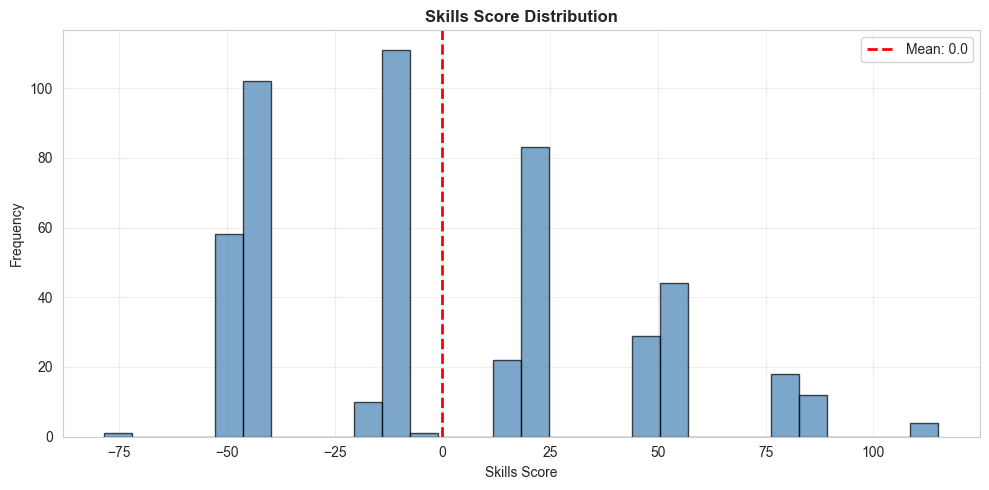

In [4]:
def calculate_skills_score(row):
    """
    Calculate skills score based on:
    - Number of skills (60%)
    - Skill diversity (40%)
    
    Returns: Score from 0-100
    """
    # Normalize number of skills (assume max is 30 for good score)
    num_skills = row.get('Num_Skills', 0)
    skills_component = min(num_skills / 30 * 100, 100) * 0.6
    
    # Diversity score (already 0-1 scale)
    diversity = row.get('Skill_Diversity', 0)
    diversity_component = diversity * 100 * 0.4
    
    return skills_component + diversity_component

# Calculate skills scores
df['Score_Skills'] = df.apply(calculate_skills_score, axis=1)

print("Skills Score Statistics:")
print(df['Score_Skills'].describe())

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(df['Score_Skills'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(df['Score_Skills'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Score_Skills"].mean():.1f}')
plt.xlabel('Skills Score')
plt.ylabel('Frequency')
plt.title('Skills Score Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2 Experience Score (0-100)

Experience Score Statistics:
count    495.000000
mean      39.985736
std        9.978349
min       27.208475
25%       31.146165
50%       39.021544
75%       46.896923
max       61.765121
Name: Score_Experience, dtype: float64


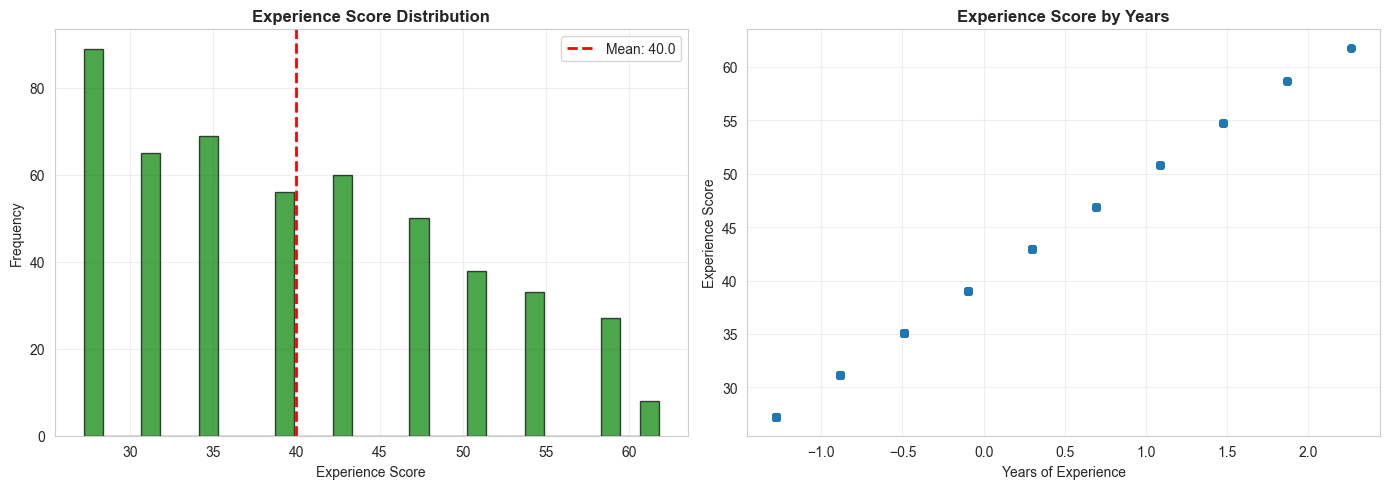

In [5]:
def calculate_experience_score(row):
    """
    Calculate experience score based on years of experience.
    - 0-2 years: 40-60
    - 3-5 years: 60-80
    - 6-8 years: 80-95
    - 9+ years: 95-100
    
    Returns: Score from 0-100
    """
    years = row.get('Experience_Years', 0)
    if pd.isna(years):
        years = 0
    
    # Non-linear scaling (logarithmic growth)
    if years == 0:
        return 20
    elif years <= 2:
        return 40 + (years / 2) * 20
    elif years <= 5:
        return 60 + ((years - 2) / 3) * 20
    elif years <= 8:
        return 80 + ((years - 5) / 3) * 15
    else:
        return min(95 + (years - 8) * 0.5, 100)

# Calculate experience scores
df['Score_Experience'] = df.apply(calculate_experience_score, axis=1)

print("Experience Score Statistics:")
print(df['Score_Experience'].describe())

# Visualize experience vs score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['Score_Experience'], bins=30, color='green', edgecolor='black', alpha=0.7)
axes[0].axvline(df['Score_Experience'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Score_Experience"].mean():.1f}')
axes[0].set_xlabel('Experience Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Experience Score Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter: Years vs Score
if 'Experience_Years' in df.columns:
    axes[1].scatter(df['Experience_Years'], df['Score_Experience'], alpha=0.5, s=30)
    axes[1].set_xlabel('Years of Experience')
    axes[1].set_ylabel('Experience Score')
    axes[1].set_title('Experience Score by Years', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 Education Score (0-100)

Education Score Statistics:
count    495.000000
mean      72.636364
std       13.726990
min       40.000000
25%       70.000000
50%       70.000000
75%       85.000000
max       85.000000
Name: Score_Education, dtype: float64


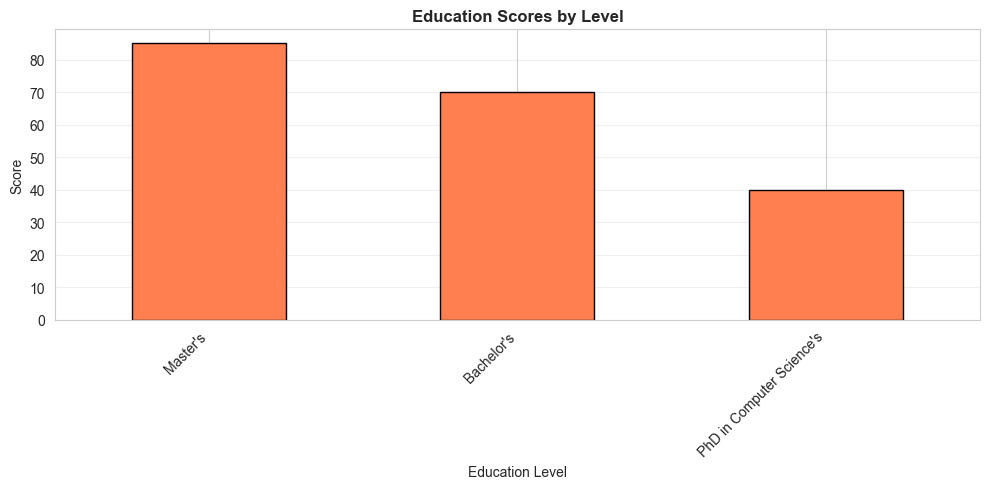

In [6]:
# Education scoring lookup
EDUCATION_SCORES = {
    'PhD': 100,
    "Master's": 85,
    "Bachelor's": 70,
    'Diploma': 50,
    'Not Specified': 40
}

def calculate_education_score(row):
    """
    Calculate education score based on highest degree.
    
    Returns: Score from 0-100
    """
    education = row.get('Education_Level', 'Not Specified')
    return EDUCATION_SCORES.get(education, 40)

# Calculate education scores
df['Score_Education'] = df.apply(calculate_education_score, axis=1)

print("Education Score Statistics:")
print(df['Score_Education'].describe())

# Visualize
if 'Education_Level' in df.columns:
    edu_scores = df.groupby('Education_Level')['Score_Education'].first().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 5))
    edu_scores.plot(kind='bar', color='coral', edgecolor='black')
    plt.xlabel('Education Level')
    plt.ylabel('Score')
    plt.title('Education Scores by Level', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

### 2.4 Bonus Scores

In [7]:
# Certification bonus (0 or 100)
if 'Has_Certification' in df.columns:
    df['Score_Certification'] = df['Has_Certification'].astype(int) * 100
elif 'Has_Certification_Encoded' in df.columns:
    df['Score_Certification'] = df['Has_Certification_Encoded'] * 100
else:
    df['Score_Certification'] = 0

# Leadership bonus (0 or 100)
if 'Has_Leadership' in df.columns:
    df['Score_Leadership'] = df['Has_Leadership'].astype(int) * 100
elif 'Has_Leadership_Encoded' in df.columns:
    df['Score_Leadership'] = df['Has_Leadership_Encoded'] * 100
else:
    df['Score_Leadership'] = 0

print("Bonus Scores:")
print(f"  Certification: {(df['Score_Certification'] > 0).sum()} candidates ({(df['Score_Certification'] > 0).sum() / len(df) * 100:.1f}%)")
print(f"  Leadership: {(df['Score_Leadership'] > 0).sum()} candidates ({(df['Score_Leadership'] > 0).sum() / len(df) * 100:.1f}%)")

Bonus Scores:
  Certification: 210 candidates (42.4%)
  Leadership: 216 candidates (43.6%)


### 2.5 Calculate Final Weighted Score

In [8]:
# Calculate weighted final score
df['Final_Score'] = (
    df['Score_Skills'] * WEIGHTS['skills'] +
    df['Score_Experience'] * WEIGHTS['experience'] +
    df['Score_Education'] * WEIGHTS['education'] +
    df['Score_Certification'] * WEIGHTS['certification'] +
    df['Score_Leadership'] * WEIGHTS['leadership']
)

print("\nFinal Score Statistics:")
print("="*60)
print(df['Final_Score'].describe())
print(f"\nScore Range: {df['Final_Score'].min():.2f} - {df['Final_Score'].max():.2f}")
print(f"Mean Score: {df['Final_Score'].mean():.2f}")
print(f"Median Score: {df['Final_Score'].median():.2f}")
print(f"Std Dev: {df['Final_Score'].std():.2f}")


Final Score Statistics:
count    495.000000
mean      30.826024
std       19.366000
min       -2.284159
25%       16.426285
50%       29.107163
75%       42.858840
max       86.312884
Name: Final_Score, dtype: float64

Score Range: -2.28 - 86.31
Mean Score: 30.83
Median Score: 29.11
Std Dev: 19.37


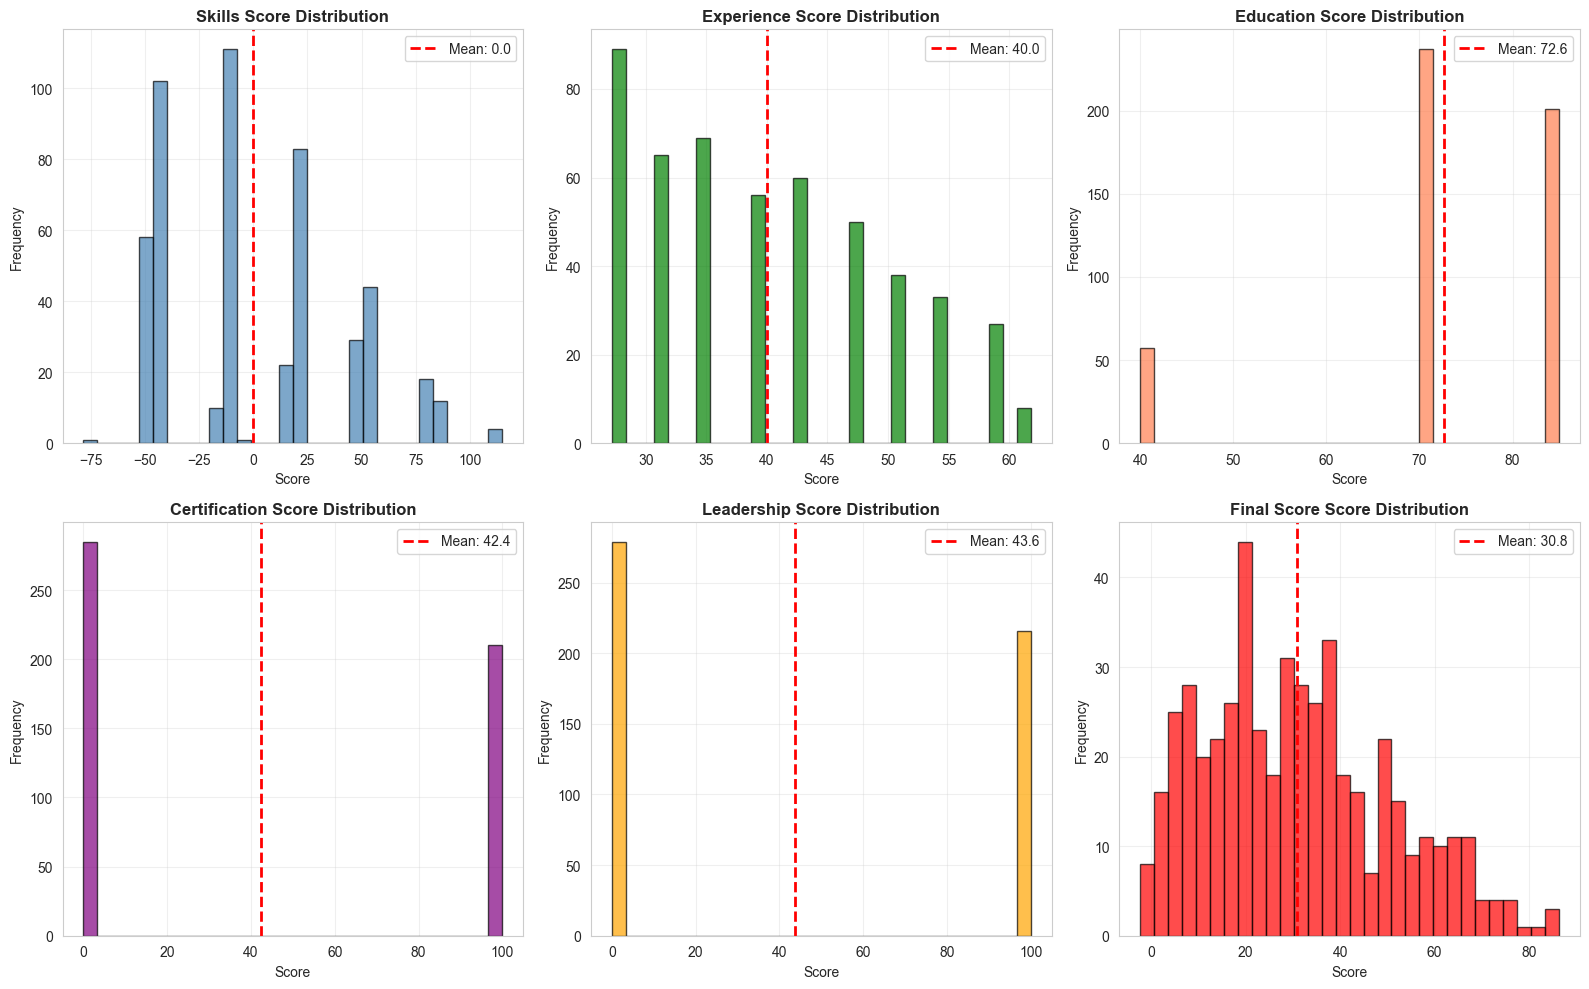

In [9]:
# Visualize score components
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Component scores
score_columns = ['Score_Skills', 'Score_Experience', 'Score_Education', 
                 'Score_Certification', 'Score_Leadership', 'Final_Score']
colors = ['steelblue', 'green', 'coral', 'purple', 'orange', 'red']
titles = ['Skills', 'Experience', 'Education', 'Certification', 'Leadership', 'Final Score']

for idx, (col, color, title) in enumerate(zip(score_columns, colors, titles)):
    axes[idx].hist(df[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, 
                     label=f'Mean: {df[col].mean():.1f}')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{title} Score Distribution', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Percentile Ranking System

Calculate where each candidate stands relative to others

Percentile Ranking Statistics:
count    495.000000
mean      50.101010
std       28.896186
min        0.202020
25%       25.151515
50%       50.303030
75%       75.050505
max      100.000000
Name: Percentile_Overall, dtype: float64


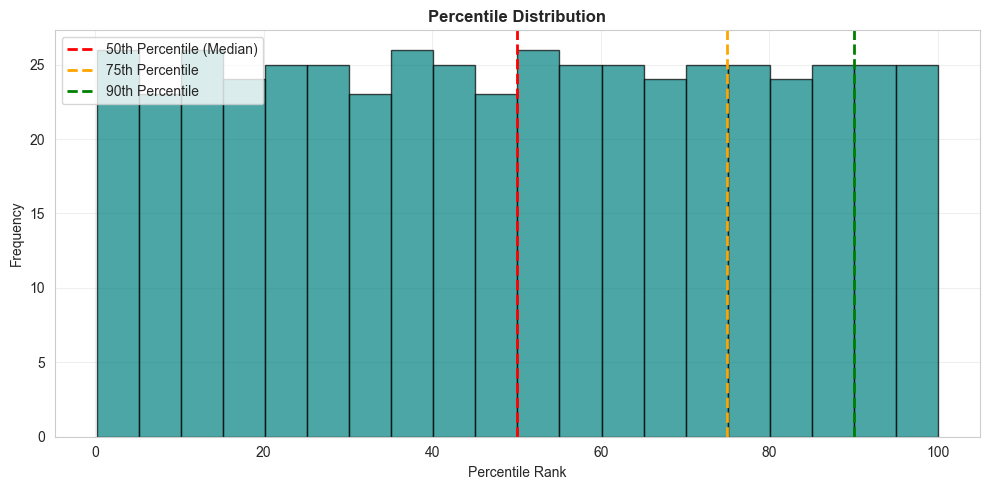

In [10]:
# Calculate overall percentile rank
df['Percentile_Overall'] = df['Final_Score'].rank(pct=True) * 100

print("Percentile Ranking Statistics:")
print("="*60)
print(df['Percentile_Overall'].describe())

# Distribution of percentiles
plt.figure(figsize=(10, 5))
plt.hist(df['Percentile_Overall'], bins=20, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(50, color='red', linestyle='--', linewidth=2, label='50th Percentile (Median)')
plt.axvline(75, color='orange', linestyle='--', linewidth=2, label='75th Percentile')
plt.axvline(90, color='green', linestyle='--', linewidth=2, label='90th Percentile')
plt.xlabel('Percentile Rank')
plt.ylabel('Frequency')
plt.title('Percentile Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Percentile Ranking by Job Category:


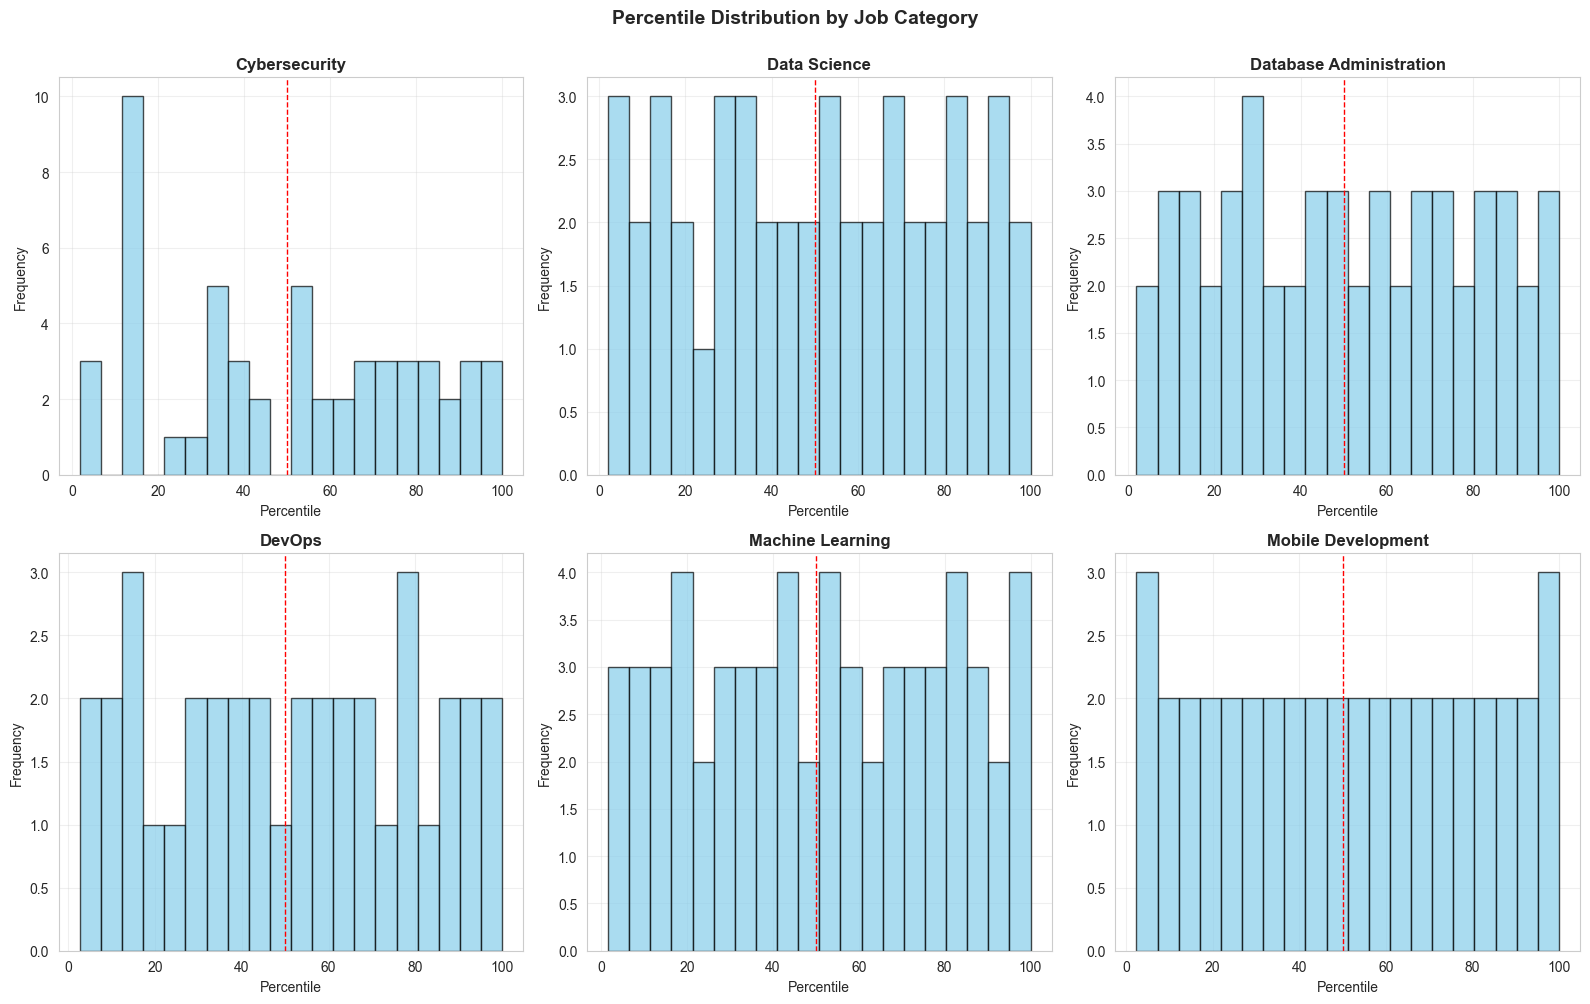

In [11]:
# Calculate percentile rank by category (if available)
if 'Category' in df.columns:
    print("\nPercentile Ranking by Job Category:")
    print("="*60)
    
    df['Percentile_Category'] = df.groupby('Category')['Final_Score'].rank(pct=True) * 100
    
    # Show distribution by category
    categories = df['Category'].unique()
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, category in enumerate(sorted(categories)[:6]):  # Show first 6 categories
        cat_data = df[df['Category'] == category]['Percentile_Category']
        axes[idx].hist(cat_data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].axvline(50, color='red', linestyle='--', linewidth=1)
        axes[idx].set_xlabel('Percentile')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{category}', fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(categories), 6):
        axes[idx].axis('off')
    
    plt.suptitle('Percentile Distribution by Job Category', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    df['Percentile_Category'] = df['Percentile_Overall']


Percentile Bands:
Percentile_Band
Below Average    123
Bottom 25%       123
Top 10%           50
Top 25%           74
Top 50%          125
Name: count, dtype: int64


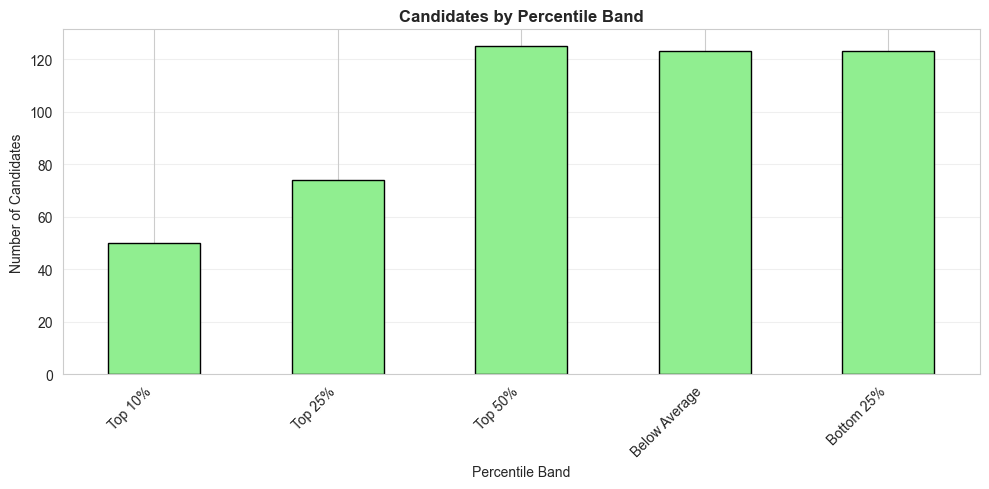

In [12]:
# Create percentile categories for interpretation
def categorize_percentile(percentile):
    """
    Categorize percentile into bands.
    """
    if percentile >= 90:
        return 'Top 10%'
    elif percentile >= 75:
        return 'Top 25%'
    elif percentile >= 50:
        return 'Top 50%'
    elif percentile >= 25:
        return 'Below Average'
    else:
        return 'Bottom 25%'

df['Percentile_Band'] = df['Percentile_Overall'].apply(categorize_percentile)

print("\nPercentile Bands:")
print(df['Percentile_Band'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 5))
band_order = ['Top 10%', 'Top 25%', 'Top 50%', 'Below Average', 'Bottom 25%']
band_counts = df['Percentile_Band'].value_counts().reindex(band_order, fill_value=0)
band_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Percentile Band')
plt.ylabel('Number of Candidates')
plt.title('Candidates by Percentile Band', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 4. Score Breakdown Analysis

In [13]:
# Show top 10 candidates
print("\nTop 10 Candidates:")
print("="*60)

top_10 = df.nlargest(10, 'Final_Score')[['Final_Score', 'Percentile_Overall', 
                                           'Score_Skills', 'Score_Experience', 
                                           'Score_Education', 'Num_Skills', 
                                           'Experience_Years']]
if 'Category' in df.columns:
    top_10 = df.nlargest(10, 'Final_Score')[['Category', 'Final_Score', 'Percentile_Overall', 
                                               'Score_Skills', 'Score_Experience', 
                                               'Score_Education']]

print(top_10.to_string())


Top 10 Candidates:
               Category  Final_Score  Percentile_Overall  Score_Skills  Score_Experience  Score_Education
225  Mobile Development    86.312884          100.000000    114.458369         61.765121               85
114  Mobile Development    86.215038           99.797980    114.458369         54.772302               70
303  Mobile Development    83.563465           99.595960    115.084822         61.765121               70
7    Mobile Development    82.532568           99.393939    113.205461         50.834613               85
139     Web Development    78.703010           99.191919     85.225032         58.709992               85
364     Web Development    76.204173           98.989899     86.477939         58.709992               70
72      Web Development    76.089815           98.787879     84.598578         50.834613               85
464     Web Development    75.953592           98.585859     85.851485         58.709992               70
185  Mobile Development   

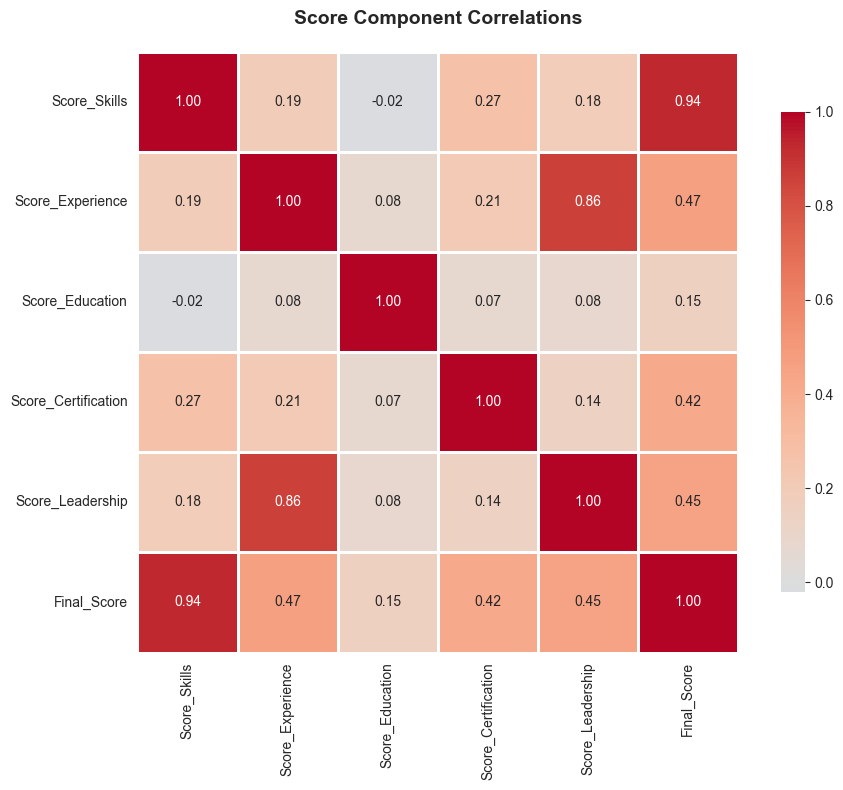

In [14]:
# Correlation between score components and final score
score_cols = ['Score_Skills', 'Score_Experience', 'Score_Education', 
              'Score_Certification', 'Score_Leadership', 'Final_Score']

plt.figure(figsize=(10, 8))
correlation_matrix = df[score_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Score Component Correlations', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 5. Job-Resume Matching (Simple Version)

Match resumes to job descriptions based on skills

In [15]:
# Load TF-IDF vectorizer
try:
    tfidf = joblib.load('../models/tfidf_vectorizer.pkl')
    print("✓ TF-IDF vectorizer loaded")
    
    # Transform resumes
    if 'Resume_Clean' in df.columns:
        resume_vectors = tfidf.transform(df['Resume_Clean'])
        print(f"  Resume vectors shape: {resume_vectors.shape}")
    else:
        print("! Resume_Clean column not found")
        resume_vectors = None
except FileNotFoundError:
    print("! TF-IDF vectorizer not found. Run feature engineering notebook first.")
    tfidf = None
    resume_vectors = None

✓ TF-IDF vectorizer loaded
  Resume vectors shape: (495, 100)


In [16]:
def match_job_to_resumes(job_description, df, resume_vectors, tfidf, top_n=10):
    """
    Match a job description to resumes using cosine similarity.
    
    Args:
        job_description (str): Job posting text
        df (pd.DataFrame): Resume dataframe
        resume_vectors: TF-IDF vectors of resumes
        tfidf: Fitted TF-IDF vectorizer
        top_n (int): Number of top matches to return
    
    Returns:
        pd.DataFrame: Top matching resumes with similarity scores
    """
    if resume_vectors is None or tfidf is None:
        print("Error: TF-IDF vectorizer not available")
        return None
    
    # Transform job description
    job_vector = tfidf.transform([job_description])
    
    # Calculate cosine similarity
    similarities = cosine_similarity(job_vector, resume_vectors)[0]
    
    # Add to dataframe temporarily
    df_temp = df.copy()
    df_temp['Match_Score'] = similarities * 100  # Convert to percentage
    
    # Get top matches
    top_matches = df_temp.nlargest(top_n, 'Match_Score')
    
    return top_matches[['Match_Score', 'Final_Score', 'Percentile_Overall', 
                        'Num_Skills', 'Experience_Years', 'Education_Level']]

# Example job description
sample_job = """
Senior Data Scientist position. Required skills: Python, Machine Learning, 
Statistics, SQL, Deep Learning, TensorFlow, Data Visualization. 
5+ years of experience. Master's degree preferred.
"""

if resume_vectors is not None:
    print("\nExample: Matching resumes to Data Scientist position")
    print("="*60)
    matches = match_job_to_resumes(sample_job, df, resume_vectors, tfidf, top_n=10)
    if matches is not None:
        print(matches.to_string())


Example: Matching resumes to Data Scientist position
     Match_Score  Final_Score  Percentile_Overall  Num_Skills  Experience_Years            Education_Level
47     74.380685    38.402828           68.383838    0.192366         -0.097846                 Bachelor's
163    69.874808    23.608326           42.020202   -0.120861         -1.279152  PhD in Computer Science's
98     68.016317    20.163246           35.454545   -0.120861         -1.279152                   Master's
367    67.286035    33.109489           58.181818    0.505593         -1.279152                   Master's
397    64.721995    20.163246           35.454545   -0.120861         -1.279152                   Master's
115    64.697569    60.394154           90.303030    1.445273          1.083461                 Bachelor's
243    64.470340    16.662083           25.656566   -0.747315         -1.279152                 Bachelor's
22     64.288286    26.845716           46.262626    0.505593         -0.885384           

## 6. BONUS: Skill Gap Analysis

In [17]:
def analyze_skill_gap(candidate_skills, job_required_skills):
    """
    Identify missing skills for a candidate.
    
    Args:
        candidate_skills (list): List of candidate's skills
        job_required_skills (list): List of required skills for job
    
    Returns:
        dict: Skill gap analysis
    """
    # Convert to lowercase for comparison
    candidate_skills_lower = [s.lower() for s in candidate_skills]
    job_required_lower = [s.lower() for s in job_required_skills]
    
    # Find matches and gaps
    matched_skills = [s for s in job_required_skills if s.lower() in candidate_skills_lower]
    missing_skills = [s for s in job_required_skills if s.lower() not in candidate_skills_lower]
    
    match_percentage = (len(matched_skills) / len(job_required_skills)) * 100 if job_required_skills else 0
    
    return {
        'matched_skills': matched_skills,
        'missing_skills': missing_skills,
        'match_percentage': match_percentage,
        'num_matched': len(matched_skills),
        'num_missing': len(missing_skills)
    }

def generate_recommendations(missing_skills):
    """
    Generate improvement recommendations based on missing skills.
    """
    if not missing_skills:
        return ["Great! You have all the required skills."]
    
    recommendations = [
        f"Consider learning: {', '.join(missing_skills[:3])}",
        "Take online courses or certifications",
        "Work on projects demonstrating these skills",
        "Update your resume once you gain these skills"
    ]
    
    return recommendations

# Example skill gap analysis
print("\nExample Skill Gap Analysis:")
print("="*60)

# Sample job requirements
job_skills = ['Python', 'Machine Learning', 'SQL', 'TensorFlow', 'Docker', 'AWS']

# Sample candidate (pick first one)
if 'Extracted_Skills' in df.columns:
    candidate_idx = 0
    candidate_skills = df.iloc[candidate_idx]['Extracted_Skills']
    
    # Parse skills if stored as string
    if isinstance(candidate_skills, str):
        import ast
        try:
            candidate_skills = ast.literal_eval(candidate_skills)
        except:
            candidate_skills = candidate_skills.split(', ')
    
    gap_analysis = analyze_skill_gap(candidate_skills, job_skills)
    
    print(f"\nJob requires: {', '.join(job_skills)}")
    print(f"\nCandidate has: {gap_analysis['num_matched']}/{len(job_skills)} skills")
    print(f"Match percentage: {gap_analysis['match_percentage']:.1f}%")
    
    if gap_analysis['matched_skills']:
        print(f"\n✓ Matched skills: {', '.join(gap_analysis['matched_skills'])}")
    
    if gap_analysis['missing_skills']:
        print(f"\n✗ Missing skills: {', '.join(gap_analysis['missing_skills'])}")
        print(f"\n💡 Recommendations:")
        for rec in generate_recommendations(gap_analysis['missing_skills']):
            print(f"   - {rec}")
else:
    print("Extracted_Skills column not found. Run feature engineering notebook first.")


Example Skill Gap Analysis:

Job requires: Python, Machine Learning, SQL, TensorFlow, Docker, AWS

Candidate has: 0/6 skills
Match percentage: 0.0%

✗ Missing skills: Python, Machine Learning, SQL, TensorFlow, Docker, AWS

💡 Recommendations:
   - Consider learning: Python, Machine Learning, SQL
   - Take online courses or certifications
   - Work on projects demonstrating these skills
   - Update your resume once you gain these skills


## 7. Save Scored Data and Models

In [18]:
# Save scored data
output_path = '../data/processed/resumes_scored.csv'
df.to_csv(output_path, index=False)
print(f"✓ Scored data saved: {output_path}")
print(f"  Shape: {df.shape}")

# Save scoring configuration
scoring_config = {
    'weights': WEIGHTS,
    'education_scores': EDUCATION_SCORES,
    'version': '1.0'
}

with open('../models/scoring_config.json', 'w') as f:
    json.dump(scoring_config, f, indent=2)
print("✓ Scoring configuration saved")

✓ Scored data saved: ../data/processed/resumes_scored.csv
  Shape: (495, 71)
✓ Scoring configuration saved


## 8. Summary

In [19]:
print("\n" + "="*80)
print("SCORING & RANKING COMPLETE")
print("="*80)

print(f"\n📊 Scoring Summary:")
print(f"  Total Candidates: {len(df)}")
print(f"  Average Score: {df['Final_Score'].mean():.2f}/100")
print(f"  Score Range: {df['Final_Score'].min():.2f} - {df['Final_Score'].max():.2f}")
print(f"  Std Deviation: {df['Final_Score'].std():.2f}")

print(f"\n🏆 Top Performers:")
print(f"  Top 10%: {(df['Percentile_Overall'] >= 90).sum()} candidates")
print(f"  Top 25%: {(df['Percentile_Overall'] >= 75).sum()} candidates")
print(f"  Top 50%: {(df['Percentile_Overall'] >= 50).sum()} candidates")

print(f"\n✅ Next step: Statistical Validation (Notebook 06)")


SCORING & RANKING COMPLETE

📊 Scoring Summary:
  Total Candidates: 495
  Average Score: 30.83/100
  Score Range: -2.28 - 86.31
  Std Deviation: 19.37

🏆 Top Performers:
  Top 10%: 50 candidates
  Top 25%: 124 candidates
  Top 50%: 249 candidates

✅ Next step: Statistical Validation (Notebook 06)
